# Artikelanalyse
## Abgleich Movex und CRH-Trade

#### 2018-01-17

In [1]:
import os
import sys
from functools import partial
import re
import math

import pandas as pd
import numpy as np
from scipy import sparse

import turbodbc
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

%matplotlib inline
sns.set(style="whitegrid")

In [2]:
sys.version

'3.6.3 |Anaconda, Inc.| (default, Nov  8 2017, 15:10:56) [MSC v.1900 64 bit (AMD64)]'

In [3]:
def batch(n, iterable):
    from scipy import sparse
    if sparse.issparse(iterable) or isinstance(
            iterable,
            (np.ndarray, np.generic)):
        row_l = iterable.shape[0]
        for ndx in range(0, row_l, n):
            yield iterable[ndx:min(ndx + n, row_l), ]

In [4]:
def create_connection_string_turbo(server, database):
    options = turbodbc.make_options(prefer_unicode=True)
    constr = 'Driver={ODBC Driver 13 for SQL Server};Server=' + \
        server + ';Database=' + database + ';Trusted_Connection=yes;'
    con = turbodbc.connect(connection_string=constr, turbodbc_options=options)
    return con

In [5]:
nan_ = np.nan

In [6]:
con = create_connection_string_turbo("CRHBUSADWH02", "AnalystCM")

In [7]:
sql = """
SET NOCOUNT ON;

IF OBJECT_ID('tempdb..#crht') IS NOT NULL DROP TABLE #crht;
IF OBJECT_ID('tempdb..#movex') IS NOT NULL DROP TABLE #movex;

SELECT [Artikelnummer]
    ,[Artikel Beschreibung]
    ,[Artikelgruppe]
    ,[Rabattgruppe]
    ,[Artikel Status]
    ,[Lieferant]
    ,[Lieferantenname]
    ,[Barcode]
    ,[Artikelserie]
    ,[MovexNr]
    ,[Lieferantennummer]
    ,[Joined on] = cast(NULL as varchar(400))
    ,[Movex Nr] = cast(NULL as varchar(400))
INTO #crht
FROM [AnalystCM].[dbo].[LOOKUP_ArtikelstammCRHT]
WHERE [Artikel Status] not in ('09', '08', '06', '10', '07')
    AND [Einmalartikel (J/N)] = 0
    AND Lieferant <> '00008537'

SELECT [Artikelnummer]
    ,[Barcode]
    ,[Artikelnummer Lieferant]
INTO #movex
FROM [AnalystCM].[dbo].[LOOKUP_ArtikelstammMOVEX]
    WHERE Artikelstatus = 'ACTIVE'
AND isVariant <> 'D' AND Lieferantennummer <> '12218'

--Join on MovexNr
update x
SET x.[Joined on] = 'Movex Nr', x.[Movex Nr] = y.[Artikelnummer]
FROM #crht x
    inner join #movex y on y.Artikelnummer = x.MovexNr
where  isnull(x.MovexNr,'') > ''

--Join on Barcode
update x
SET x.[Joined on] = 'Barcode', x.[Movex Nr] = y.[Artikelnummer]
FROM #crht x
    inner join #movex y 
        on replace(replace(y.Barcode, ' ', ''), '.','') = replace(replace(x.Barcode, ' ', ''), '.','') collate SQL_Latin1_General_CP1_CI_AI
WHERE x.[Movex Nr] is null
and isnull(replace(replace(y.Barcode, ' ', ''), '.',''),'')>'' and isnull(replace(replace(x.Barcode, ' ', ''), '.',''),'')>''

--Join on Herstellernummer
update x
SET x.[Joined on] = 'Herstellernummer', x.[Movex Nr] = y.[Artikelnummer]
FROM #crht x
    inner join #movex y
        on replace(replace(replace(y.[Artikelnummer Lieferant], ' ', ''), '.',''),'-','') = replace(replace(replace(x.[Lieferantennummer], ' ', ''), '.',''),'-','') collate SQL_Latin1_General_CP1_CI_AI
WHERE x.[Movex Nr] is null
and isnull(replace(replace(replace(y.[Artikelnummer Lieferant], ' ', ''), '.',''),'-',''),'')>'' and isnull(replace(replace(replace(x.[Lieferantennummer], ' ', ''), '.',''),'-',''),'')>''

SELECT * FROM #crht

IF OBJECT_ID('tempdb..#crht') IS NOT NULL DROP TABLE #crht;
IF OBJECT_ID('tempdb..#movex') IS NOT NULL DROP TABLE #movex;
"""

crht = pd.read_sql(sql, con)
crht = crht.replace('', nan_).fillna(nan_)
crht.columns = ['_'.join(i.split(' ')) for i in crht.columns]
crht.drop_duplicates(inplace=True)

print("Anzahl Zeilen (CRH Trade) = {}".format(crht.shape[0]))

Anzahl Zeilen (CRH Trade) = 420382


In [8]:
sql = """
    SET NOCOUNT ON

    SELECT [Sparte]
      ,[Artikelnummer]
      ,[Artikel Bezeichnung]
      ,[Artikel Bezeichnung franz.]
      ,[Artikelgruppe]
      ,[Lieferantennummer]
      ,[Lieferantenname]
      ,[Barcode]
      ,[Artikelstatus]
      ,[Artikelnummer Lieferant]
      ,[Serie]
    FROM [AnalystCM].[dbo].[LOOKUP_ArtikelstammMOVEX]
        WHERE Artikelstatus = 'ACTIVE'
    AND isVariant <> 'D' AND Lieferantennummer <> '12218'
"""
movex = pd.read_sql(sql, con)
movex = movex.replace('', nan_).fillna(nan_)
movex.columns = ['_'.join(i.split(' ')) for i in movex.columns]
crht.drop_duplicates(inplace=True)

print("Anzahl Zeilen (Movex) = {}".format(movex.shape[0]))

Anzahl Zeilen (Movex) = 379312


In [9]:
gsql = """
SELECT distinct 
      Artikelgruppe = [idItemGroupOrigin]
     ,Produktgruppe = [ItemGroupGroupHierarchyName_L1]
FROM crhbusadwh01.[InfoPool].[DIM].[ItemGroup]
"""
group_crht = pd.read_sql(gsql, con)


gsql = """
SELECT distinct 
      Artikelgruppe = [idItemGroupOrigin]
      ,Produktgruppe = [ItemGroupGroupHierarchyName_GER_L1]
FROM [InfoPool_MOV].[DIM].[ItemGroup]
"""
group_movex = pd.read_sql(gsql, con)

In [10]:
movex = movex.merge(group_movex, how='left', on='Artikelgruppe')
crht = crht.merge(group_crht, how='left', on='Artikelgruppe')

## Statistiken zum Artikelstamm

### Abgeglichene und nicht nicht abgeglichene Artikel

In [11]:
matched = crht[~pd.isnull(crht['Movex_Nr'])].copy()
number_of_matched = matched.shape[0]
print("{} gematchte Artikel".format(number_of_matched))

non_matched_crht = crht[pd.isnull(crht['Movex_Nr'])].copy()
number_of_non_matched_crht = non_matched_crht.shape[0]
print("{} nicht gematchte Artikel in CRH Trade".format(number_of_non_matched_crht))

matched_movexnr = crht[~pd.isnull(crht['Movex_Nr'])]['Movex_Nr'].unique()
non_matched_movex = movex.query('Artikelnummer not in @matched_movexnr').copy()
number_of_non_matched_movex = non_matched_movex.shape[0]
print("{} nicht gematchte Artikel in Movex".format(number_of_non_matched_movex))

176208 gematchte Artikel
244174 nicht gematchte Artikel in CRH Trade
207589 nicht gematchte Artikel in Movex


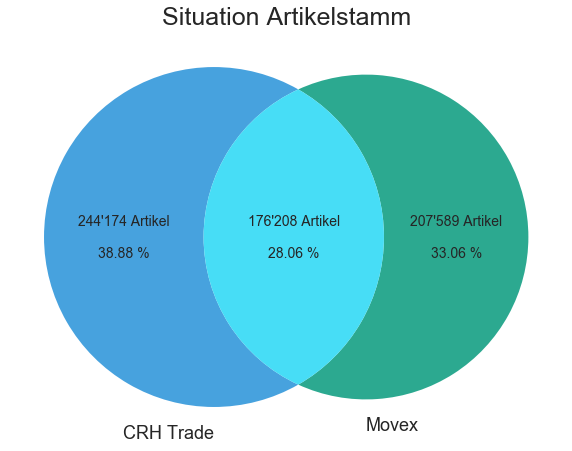

In [12]:
l = (number_of_non_matched_crht,
     number_of_non_matched_movex,
     number_of_matched)

total = np.sum(l)

t = []
for i in l:
    t += ["{}'{} Artikel\n\n{} %".format(
        str(i)[:3], str(i)[-3:],
        round(i / total * 100, 2))]
    
## First way to call the 2 group Venn diagram:
f, ax = plt.subplots(figsize=(10,10))
## First way to call the 2 group Venn diagram:
out = venn2(subsets = l,
      set_labels = ('CRH Trade', 'Movex'), alpha=0.9,
      ax=ax, set_colors=('#3498db', '#16a085'))

for text in out.set_labels:
    text.set_fontsize(18)
    
for text, label_ in zip(out.subset_labels, t):
    text.set_fontsize(14)
    text.set_text(label_)

plt.title("Situation Artikelstamm", {"fontsize": 25})
plt.savefig('Venn-Diagramm.pdf')
plt.savefig('Venn-Diagramm.png')
plt.show()

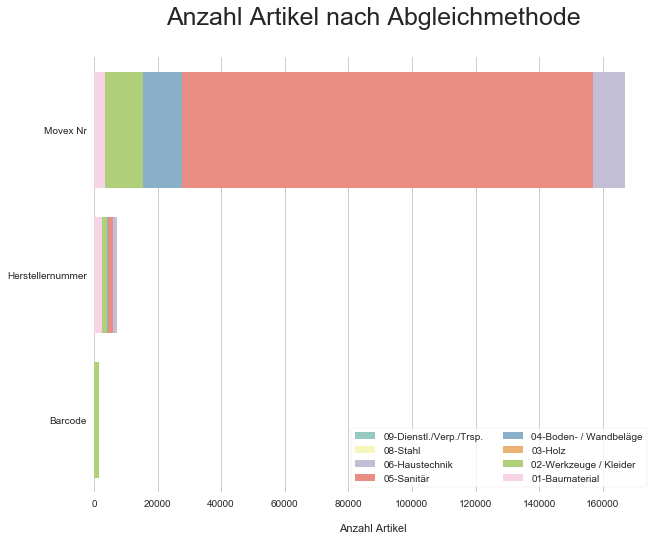

In [13]:
byPG = matched.groupby(['Joined_on', 'Produktgruppe'], as_index=False)['Artikelnummer'].count()
byPG.columns=['Joined_on','Produktgruppe', 'Anzahl Artikel']
byPG['Anzahl Artikel kum'] = byPG.groupby(['Joined_on'])['Anzahl Artikel'].transform('cumsum')
byPG = byPG.sort_values('Anzahl Artikel kum', ascending=False)

f, ax = plt.subplots(figsize=(10, 8))

upg = byPG.Produktgruppe.unique()
col_ = sns.color_palette("Set3", n_colors=len(upg))

for i,j in zip(upg, col_):
    data = byPG.query('Produktgruppe == "{}"'.format(i))
    sns.barplot(x="Anzahl Artikel kum", y="Joined_on", data=data,
                label=i, color=j)

ax.set(ylabel="", xlabel="\nAnzahl Artikel")
sns.despine(left=True, bottom=True)
plt.title("Anzahl Artikel nach Abgleichmethode\n", {"fontsize": 25})
ax.legend(ncol=2, loc="lower right", frameon=True)
plt.savefig('Bar-Chart.pdf')
plt.savefig('Bar-Chart.png')
plt.show()

## Artikel Abgleich via Textdistanz

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances

In [15]:
vec = CountVectorizer()
vec.fit(non_matched_crht['Artikel_Beschreibung'])

vec_crht = vec.transform(non_matched_crht['Artikel_Beschreibung'])
vec_movex = vec.transform(non_matched_movex['Artikel_Bezeichnung'])

print(vec_crht.shape)
print(vec_movex.shape)

(244174, 31280)
(207589, 31280)


In [16]:
# too memory heavy, no chance to do it without batching (32 GB Ram VM)
chunksize = 2500

batcher = partial(batch, chunksize)
idx = np.zeros(shape=(vec_crht.shape[0], 1), dtype=np.int)
dist = np.zeros(shape=(vec_crht.shape[0], 1), dtype=np.float)

print("Number of Batches = {}".format(math.ceil(vec_crht.shape[0] / chunksize)))

for i,j,v in tqdm(zip(batcher(idx),batcher(dist), batcher(vec_crht))):
    d = pairwise_distances(v, vec_movex, metric='cosine')
    i[:,0] = d.argmin(axis=1)
    j[:,0] = d.min(axis=1)

Number of Batches = 98


98it [31:50, 23.43s/it]


In [17]:
matched_backup = matched.copy()
non_matched_crht_backup = non_matched_crht.copy()
non_matched_movex_backup = non_matched_movex.copy()


#matched = matched_backup.copy()
#non_matched_crht = non_matched_crht_backup.copy()
#non_matched_movex = non_matched_movex_backup.copy()

In [18]:
text_matching = non_matched_crht.copy()

text_matching['movex_idx_y'] = idx
text_matching['movex_dist_y'] = dist

mmap = dict(enumerate(non_matched_movex['Artikelnummer']))

text_matching['Movex_Nr'] = text_matching['movex_idx_y'].map(mmap)

ii = []
for i in range(0, 105, 5):
    h = i/100.0
    ii += [(h, text_matching.query('movex_dist_y < @h').shape[0])]

ii = pd.DataFrame(ii)
ii.columns = ['Threshold', 'Number of Matched Articles']

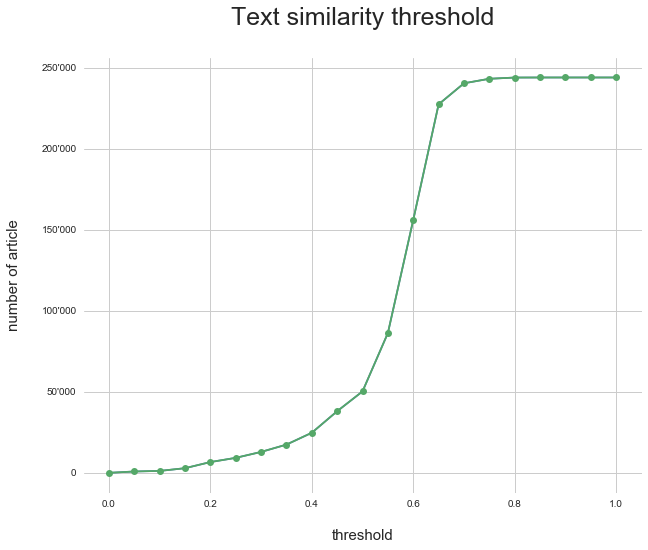

In [19]:
f, ax = plt.subplots(figsize=(10, 8))

x = ii.iloc[:,0]
y = ii.iloc[:,1]

plt.plot(x, y)
plt.plot(x, y, marker='o')
ax.set(ylabel="number of article\n", xlabel="\nthreshold")
ax.yaxis.label.set_size(15)
ax.xaxis.label.set_size(15)
vals = ax.get_yticks()
ax.set_yticklabels([format(int(i), ",").replace(",", "'") for i in vals])
sns.despine(left=True, bottom=True)
plt.title("Text similarity threshold\n", {"fontsize": 25})
plt.savefig('Matching_Threshold.pdf')
plt.savefig('Matching_Threshold.png')
plt.show()

In [20]:
threshold = 0.2

non_matched_crht['movex_idx_y'] = idx
non_matched_crht['movex_dist_y'] = dist

mmap = dict(enumerate(non_matched_movex['Artikelnummer']))

non_matched_crht['Movex_Nr'] = non_matched_crht['movex_idx_y'].map(mmap)
non_matched_crht.loc[non_matched_crht['movex_dist_y']>threshold, 'Movex_Nr'] = nan_

g = non_matched_crht.groupby('Movex_Nr')['movex_dist_y'].rank(
    method='first', ascending=True) == 1

non_matched_crht.loc[~g, 'Movex_Nr'] = nan_
non_matched_crht.loc[~pd.isnull(non_matched_crht['Movex_Nr']), 'Joined_on'] = 'Text'
non_matched_crht.drop([i for i in non_matched_crht.columns if i.endswith('_y')], axis=1, inplace=True)

In [21]:
# non_matched_crht.merge(movex, how='inner', left_on='Movex_Nr', right_on="Artikelnummer", suffixes=('','_y')).to_clipboard()
len(non_matched_crht['Movex_Nr'].unique()) == sum(~pd.isnull(non_matched_crht['Movex_Nr']))+1

True

In [22]:
matched = pd.concat([matched, non_matched_crht[~pd.isnull(non_matched_crht['Movex_Nr'])]], axis=0, copy=True)
non_matched_crht = non_matched_crht[pd.isnull(non_matched_crht['Movex_Nr'])].copy()
matched_movexnr = matched['Movex_Nr'].unique()
non_matched_movex = movex.query('Artikelnummer not in @matched_movexnr').copy()

## Abgeglichene Artikel nach Textabgleich

In [23]:
number_of_matched = matched.shape[0]
number_of_non_matched_crht = non_matched_crht.shape[0]
number_of_non_matched_movex = non_matched_movex.shape[0]

print("{} gematchte Artikel".format(number_of_matched))
print("{} nicht gematchte Artikel in CRH Trade".format(number_of_non_matched_crht))
print("{} nicht gematchte Artikel in Movex".format(number_of_non_matched_movex))

177927 gematchte Artikel
242455 nicht gematchte Artikel in CRH Trade
205870 nicht gematchte Artikel in Movex


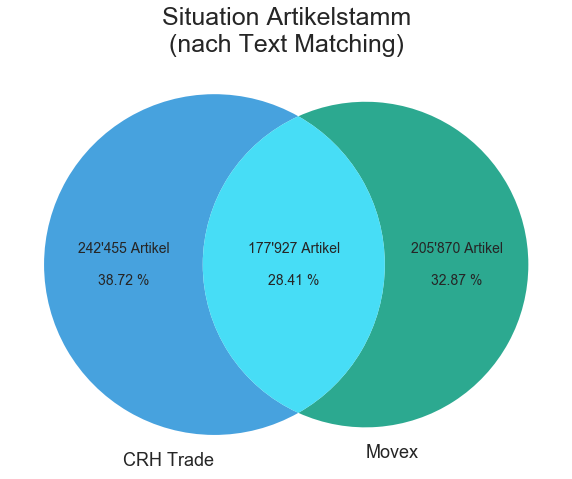

In [24]:
l = (number_of_non_matched_crht,
     number_of_non_matched_movex,
     number_of_matched)

total = np.sum(l)

t = []
for i in l:
    t += ["{}'{} Artikel\n\n{} %".format(
        str(i)[:3], str(i)[-3:],
        round(i / total * 100, 2))]
    
## First way to call the 2 group Venn diagram:
f, ax = plt.subplots(figsize=(10,10))
## First way to call the 2 group Venn diagram:
out = venn2(subsets = l,
      set_labels = ('CRH Trade', 'Movex'), alpha=0.9,
      ax=ax, set_colors=('#3498db', '#16a085'))

for text in out.set_labels:
    text.set_fontsize(18)
    
for text, label_ in zip(out.subset_labels, t):
    text.set_fontsize(14)
    text.set_text(label_)

plt.title("Situation Artikelstamm\n(nach Text Matching)", {"fontsize": 25})
plt.savefig('Venn-Diagramm-Text-Matching.pdf')
plt.savefig('Venn-Diagramm-Text-Matching.png')
plt.show()

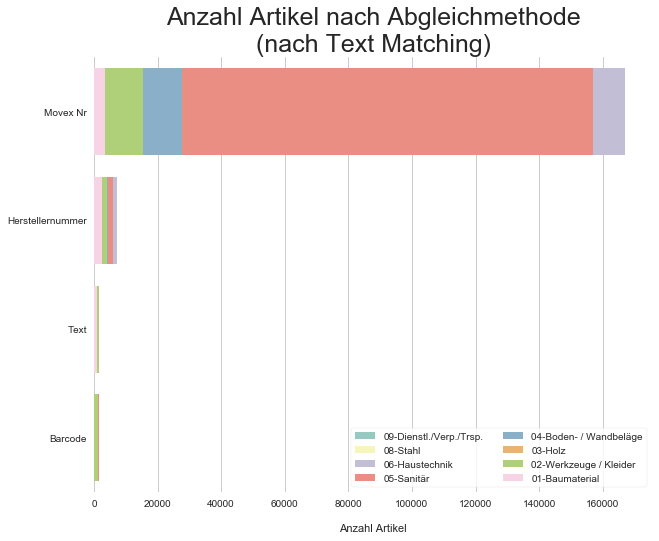

In [25]:
byPG = matched.groupby(['Joined_on', 'Produktgruppe'], as_index=False)['Artikelnummer'].count()
byPG.columns=['Joined_on','Produktgruppe', 'Anzahl Artikel']
byPG['Anzahl Artikel kum'] = byPG.groupby(['Joined_on'])['Anzahl Artikel'].transform('cumsum')
byPG = byPG.sort_values('Anzahl Artikel kum', ascending=False)

f, ax = plt.subplots(figsize=(10, 8))

upg = byPG.Produktgruppe.unique()
col_ = sns.color_palette("Set3", n_colors=len(upg))

for i,j in zip(upg, col_):
    data = byPG.query('Produktgruppe == "{}"'.format(i))
    sns.barplot(x="Anzahl Artikel kum", y="Joined_on", data=data,
                label=i, color=j)

ax.set(ylabel="", xlabel="\nAnzahl Artikel")
sns.despine(left=True, bottom=True)
plt.title("Anzahl Artikel nach Abgleichmethode\n(nach Text Matching)", {"fontsize": 25})
ax.legend(ncol=2, loc="lower right", frameon=True)
plt.savefig('Bar-Chart-Text-Matching.pdf')
plt.savefig('Bar-Chart-Text-Matching.png')
plt.show()

In [26]:
matched.columns = ['CRHT_Nr', 'Artikel_Beschreibung_CRHT', 'Artikelgruppe',
       'Rabattgruppe', 'Artikel_Status', 'Lieferant', 'Lieferantenname',
       'Barcode', 'Artikelserie', 'MovexNr', 'Lieferantennummer', 'Joined_on',
       'Movex_Nr', 'Produktgruppe']

non_matched_crht.columns = ['CRHT_Nr', 'Artikel_Beschreibung_CRHT', 'Artikelgruppe',
       'Rabattgruppe', 'Artikel_Status', 'Lieferant', 'Lieferantenname',
       'Barcode', 'Artikelserie', 'MovexNr', 'Lieferantennummer', 'Joined_on',
       'Movex_Nr', 'Produktgruppe']


matched['Artikel_Beschreibung_Movex'] = nan_
non_matched_crht['Artikel_Beschreibung_Movex'] = nan_
matched['Typ'] = 'Matched'
non_matched_crht['Typ'] = 'Nicht gematched CRHT'

In [27]:
non_matched_movex.columns = ['Sparte', 'Artikelnummer', 'Artikel_Beschreibung_Movex',
                           'Artikel_Beschreibung_franz.', 'Artikelgruppe', 'Lieferant',
                           'Lieferantenname', 'Barcode', 'Artikel_Status',
                           'Lieferantennummer', 'Artikelserie', 'Produktgruppe']

non_matched_movex['Movex_Nr'] = non_matched_movex['Artikelnummer']
non_matched_movex['Artikel_Beschreibung_CRHT'] = nan_
non_matched_movex['Rabattgruppe'] = nan_
non_matched_movex['CRHT_Nr'] = nan_
non_matched_movex['Joined_on'] = nan_

non_matched_movex['Typ'] = 'Nicht gematched Movex'

In [28]:
cols_ = ['CRHT_Nr','Movex_Nr', 'Artikel_Beschreibung_CRHT', 'Artikel_Beschreibung_Movex',
         'Artikelgruppe', 'Rabattgruppe', 'Artikel_Status', 'Lieferant', 'Lieferantenname',
         'Barcode', 'Artikelserie', 'Lieferantennummer',
         'Produktgruppe', 'Typ', 'Joined_on']

non_matched_movex = non_matched_movex[cols_]
matched = matched[cols_]
non_matched_crht = non_matched_crht[cols_]

In [29]:
final_df = pd.concat([matched, non_matched_crht, non_matched_movex])

In [30]:
d = {i[0]:i[1] for i in movex[['Artikelnummer', 'Artikel_Bezeichnung']].values}
final_df['Artikel_Beschreibung_Movex'] = final_df['Movex_Nr'].map(d)

In [31]:
final_df.head()

,CRHT_Nr,Movex_Nr,Artikel_Beschreibung_CRHT,Artikel_Beschreibung_Movex,Artikelgruppe,Rabattgruppe,Artikel_Status,Lieferant,Lieferantenname,Barcode,Artikelserie,Lieferantennummer,Produktgruppe,Typ,Joined_on
449,2044743,45282521,Nella-1230 Bodenplatte monokalibriert\300x1200...,TREVERKHOME MJWK ROVERE REKTIFIZIERT R9...,6000,FK,03,00004907,Marazzi Group S.r.l.,NaN,TREVERK HOME,MAR MJWK,04-Boden- / Wandbeläge,Matched,Movex Nr
450,2044744,45282520,Nella-1231 Bodenplatte monokalibriert\300x1200...,TREVERKHOME MJWJ BETULLA REKTIFIZIERT R9...,6000,FK,03,00004907,Marazzi Group S.r.l.,NaN,TREVERK HOME,MAR MJWJ,04-Boden- / Wandbeläge,Matched,Movex Nr
451,2044746,45282523,Nella-1233 Bodenplatte\monokalibriert\300x1200...,TREVERKHOME MJWM QUERCIA REKTIFIZIERT R9...,6000,FK,03,00004907,Marazzi Group S.r.l.,NaN,TREVERK HOME,MAR MJWM,04-Boden- / Wandbeläge,Matched,Movex Nr
452,2044750,45282503,Nella-1213 Bodenplatte\monokalibriert\150x1200...,TREVERKHOME MJWD QUERCIA REKTIFIZIERT R9...,6000,FK,03,00004907,Marazzi Group S.r.l.,NaN,TREVERK HOME,MAR MJWD,04-Boden- / Wandbeläge,Matched,Movex Nr
453,2044753,45282512,Nella-1222 Bodenplatte\monokalibriert\200x1200...,TREVERKHOME MJWG CASTAGNO REKTIFIZIERT R9...,6000,FK,03,00004907,Marazzi Group S.r.l.,NaN,TREVERK HOME,MAR MJWG,04-Boden- / Wandbeläge,Matched,Movex Nr


In [32]:
# final_df.to_clipboard()
final_df.to_csv("Item_Analysis_Full_Table.csv", sep='\t', index=False)
non_matched_crht.to_csv("Item_Analysis_Non_Matched_CRHT.csv", sep='\t', index=False)
non_matched_movex.to_csv("Item_Analysis_Non_Matched_Movex.csv", sep='\t', index=False)
matched.to_csv("Item_Analysis_Matched.csv", sep='\t', index=False)
crht.to_csv("Item_Analysis_Source_CRHT.csv", sep='\t', index=False)
movex.to_csv("Item_Analysis_Source_Movex.csv", sep='\t', index=False)

In [33]:
print("Done....")

Done....
